In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm


# CONFIGS

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check if GPU is available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Settings

MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 3

TEXT_COL = 'text'
TARGET_COL = 'status'

Using device: cpu


In [11]:

# Load the dataset

DATA_PATH = 'D:\\Mental-Health-Classification\\data\\mental_heath_unbanlanced.csv'
data = pd.read_csv(DATA_PATH)


# Display the first few rows of the dataset

print("First few rows of the dataset:")
print(data.head())


# Validate your dataset has the required columns before proceeding

assert TEXT_COL in data.columns, f"{TEXT_COL} not in columns: {data.columns}" 
assert TARGET_COL in data.columns, f"{TARGET_COL} not in columns: {data.columns}"


First few rows of the dataset:
   Unique_ID                                               text   status
0        0.0                                         oh my gosh  Anxiety
1        1.0  trouble sleeping, confused mind, restless hear...  Anxiety
2        2.0  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3        3.0  I've shifted my focus to something else but I'...  Anxiety
4        4.0  I'm restless and restless, it's been a month n...  Anxiety


In [12]:
# Data Balance Check

X = data[TEXT_COL]
y = data[TARGET_COL]
print("\nClass distribution in the dataset:")
print(data[TARGET_COL].value_counts())

# Split the dataset into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Encode Labels

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Compute Class Weights

classes = np.unique(y_train_encoded)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_encoded)

class_weights = torch.tensor(
    class_weights_array,
    dtype=torch.float
    ).to(device)

print("\nClass weights (to handle imbalance):")
for idx, weight in enumerate(class_weights_array):
    class_name = label_encoder.classes_[idx]
    count = np.sum(y_train_encoded == idx)
    print(f"  {class_name:12s}: weight={weight:.4f}, count={count:,}")


Class distribution in the dataset:
status
Normal        18391
Depression    14506
Suicidal      11212
Anxiety        5503
Name: count, dtype: int64

Class weights (to handle imbalance):
  Anxiety     : weight=2.2540, count=4,402
  Depression  : weight=0.8550, count=11,605
  Normal      : weight=0.6744, count=14,713
  Suicidal    : weight=1.1063, count=8,969


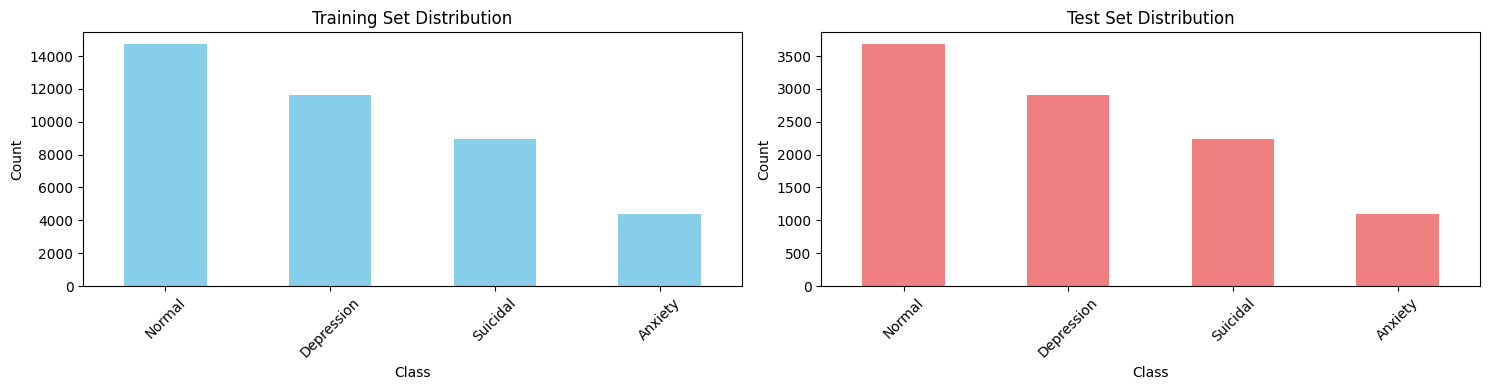

In [13]:
# Visualize The Class Distribution

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

pd.Series(y_test).value_counts().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Test Set Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [14]:
# Create PyTorch Dataset

class MentalHealthDataset(Dataset):
    def __init__(self, texts,labels,tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)

    def __getitem__(self,idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text.tolist(),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(), # Transform 2D Shape to 1D
            'attention_mask': encoding['attention_mask'].flatten(), # Ignore the padding Tokens
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [16]:
# Tokenizer

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

train_dataset_tesor = MentalHealthDataset(
    texts=X_train,
    labels=y_train_encoded,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

test_dataset_tesor = MentalHealthDataset(
    texts=X_test,
    labels=y_test_encoded,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

# Data Loaders

train_loader = DataLoader(
    train_dataset_tesor,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset_tesor,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

  Batch size: 16
  Training batches: 2481
  Test batches: 621


In [17]:
# Model Initialization

model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_encoder.classes_)
)

# Move model to GPU/CPU
model.to(device)
print(f"Model loaded: {MODEL_NAME}")
print(f"Number of labels: {len(label_encoder.classes_)}")
print(f"Model moved to: {device}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: distilbert-base-uncased
Number of labels: 4
Model moved to: cpu


In [ ]:
# Optimizers and Loss Function  

def train_epochs(model, data_loader, optimizer, loss_fn, device):
    
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    # Progression 
    
    progress_bar = tqdm(data_loader, desc='Training') # Create a progress bar for training
    
    for batch in progress_bar:
        
        # Get data from batch and move to device
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward Pass
        
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask, 
        )
        
        logits = output.logits
        
        # Loss Calculation
        
        loss = loss_fn(logits, labels)
        
        # Backward Pass and Optimization
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accuracy
        
        pred = torch.argmax(logits, dim=1)
        correct_predictions = correct_predictions + (pred == labels).sum().item()
        total_samples = total_samples + labels.size(0)
        total_loss = total_loss + loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}", 
                                  'accuracy': f'{correct_predictions/total_samples:.4f}'})
        
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy